# 제품 이상여부 판별 프로젝트


## 1. 데이터 불러오기


### 필수 라이브러리


In [522]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

### 데이터 읽어오기


In [523]:
RANDOM_STATE = 110

train_data = pd.read_csv("train_data_forEDA.csv")
test_data = pd.read_csv("test_data_forEDA.csv")

---

반복적으로 쓰는 툴 함수화

In [524]:
def plot_box(dataframe, column_name):
    """
    주어진 데이터프레임과 열 이름에 대해 박스 플롯을 그리는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    """
    plt.figure(figsize=(10, 6))
    plt.boxplot(dataframe[column_name], vert=False)
    plt.xlabel(column_name)
    plt.title(f'Box Plot of {column_name}')
    plt.show()

In [525]:
import pandas as pd

def value_counts_ratio_count(df, col_name, target_name):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 비율과 갯수, 총 갯수를 출력하는 함수.

    Parameters:
    df (pd.DataFrame): 데이터프레임
    col_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    """
    # 각 값마다 타겟 변수의 비율 계산
    value_counts = df.groupby(col_name)[target_name].value_counts(normalize=True).unstack().fillna(0)
    
    # 각 값마다 타겟 변수의 갯수 계산
    counts = df.groupby(col_name)[target_name].value_counts().unstack().fillna(0)
    
    # 각 값마다 총 갯수 계산
    total_counts = df[col_name].value_counts().rename('Total_Count')
    
    # 비율과 갯수를 합침
    result = value_counts.join(counts, lsuffix='_ratio', rsuffix='_count')
    
    # 총 갯수를 합침
    result = result.join(total_counts, on=col_name)
    
    # 출력 형식 조정
    result.index.name = 'variable'
    print(f"\n{col_name}별 {target_name} 비율 및 갯수\n")
    print(result.rename(columns=lambda x: x.split('_')[0]))

In [526]:
import pandas as pd

def summarize_grouped_data(df, group_by_columns):
    # 데이터프레임을 그룹화
    grouped_df = df.groupby(group_by_columns)
    
    # 결과를 저장할 리스트 초기화
    results = []
    
    # 그룹화된 데이터프레임의 내용을 확인하는 코드
    for name, group in grouped_df:
        # 그룹의 갯수 계산
        group_count = group.shape[0]
        
        # 'target' 변수의 'AdNormal' 비율과 갯수 계산
        adnormal_count = group['target'].value_counts().get('AbNormal', 0)
        adnormal_ratio = adnormal_count / group_count
        
        # 결과 리스트에 추가
        results.append([name, adnormal_count, adnormal_ratio, group_count])
    
    # 결과 리스트를 데이터프레임으로 변환
    results_df = pd.DataFrame(results, columns=['group', "'AdNormal' count", 'ratio', 'Total'])
    
    # 그룹화된 변수들의 이름을 제목행으로 출력
    print(f"Grouped by: {', '.join(group_by_columns)}")
    print()
    # 데이터프레임 출력
    print(results_df)
    
    return results_df

In [527]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

def plot_abnormal_ratio(dataframe, column_name, target_name, target_value, bins=20):
    """
    주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하고 막대그래프로 표시하는 함수.

    Parameters:
    dataframe (pd.DataFrame): 데이터프레임
    column_name (str): 열 이름
    target_name (str): 타겟 변수 이름
    target_value (str): 타겟 변수의 특정 값
    bins (int): 구간의 수 (기본값은 20)
    """
    def abnormal_ratio(dataframe, column_name, target_name, target_value):
        """
        주어진 데이터프레임의 특정 열에 대해 각 값마다 타겟 변수의 특정 값 비율을 계산하는 함수.

        Parameters:
        dataframe (pd.DataFrame): 데이터프레임
        column_name (str): 열 이름
        target_name (str): 타겟 변수 이름
        target_value (str): 타겟 변수의 특정 값

        Returns:
        pd.DataFrame: 각 값마다 타겟 변수의 특정 값 비율을 포함하는 데이터프레임
        """
        # 각 값마다 타겟 변수의 특정 값 비율 계산
        value_counts = dataframe.groupby(column_name)[target_name].apply(lambda x: (x == target_value).mean()).reset_index()
        count_counts = dataframe.groupby(column_name)[target_name].count().reset_index()
        
        value_counts.columns = [column_name, 'ratio']
        count_counts.columns = [column_name, 'count']
        
        # 비율과 카운트를 병합
        result = pd.merge(value_counts, count_counts, on=column_name)
        return result

    # column_name 값을 지정된 구간으로 나누기
    dataframe[f'{column_name}_bins'] = pd.cut(dataframe[column_name], bins=bins)

    # 비율 계산
    ratios = abnormal_ratio(dataframe, f'{column_name}_bins', target_name, target_value)

    # 막대그래프 그리기
    plt.figure(figsize=(20, 10))
    barplot = sns.barplot(x=f'{column_name}_bins', y='ratio', data=ratios, color='skyblue')
    plt.xlabel(f'{column_name} (binned)')
    plt.ylabel('AbNormal Ratio')
    plt.title(f'AbNormal Ratio by {column_name} (binned)', pad=30)  # 제목과 그래프 사이의 간격 조정
    plt.xticks(rotation=45)
    plt.ylim(0, 1)

    # 각 막대 위에 비율 값과 카운트 표시
    for p in barplot.patches:
        # 막대의 x 좌표에 해당하는 구간을 찾기
        bin_label = ratios[f'{column_name}_bins'].cat.categories[int(p.get_x() + p.get_width() / 2) - 1]
        count_value = ratios.loc[ratios[f'{column_name}_bins'] == bin_label, 'count'].values[0]
        barplot.annotate(f'{format(p.get_height(), ".2f")} ({count_value})', 
                         (p.get_x() + p.get_width() / 2., p.get_height()), 
                         ha='center', va='center', 
                         xytext=(0, 9), 
                         textcoords='offset points')

    plt.show()

    # _bins 변수 드랍
    dataframe.drop(columns=[f'{column_name}_bins'], inplace=True)


---

## Dam

## AutoClave

## Fill1

In [528]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine T

### RESIN 관련 변수 처리

In [529]:
value_counts_ratio_count(train_data, 'DISCHARGED SPEED OF RESIN Collect Result_Fill1', 'target')


DISCHARGED SPEED OF RESIN Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
0.0       1.000000  0.000000       1.0      0.0      1
8.0       0.053292  0.946708      17.0    302.0    319
10.6      0.053958  0.946042    1940.0  34014.0  35954
10.9      0.092628  0.907372     392.0   3840.0   4232


In [530]:
value_counts_ratio_count(train_data, 'DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1', 'target')


DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
0.0       1.000000  0.000000       1.0      0.0      1
3.9       0.104167  0.895833       5.0     43.0     48
4.0       0.000000  1.000000       0.0     38.0     38
12.6      0.125000  0.875000       2.0     14.0     16
12.7      0.100000  0.900000      17.0    153.0    170
12.8      0.049237  0.950763     142.0   2742.0   2884
12.9      0.046340  0.953660     395.0   8129.0   8524
13.2      0.095791  0.904209      66.0    623.0    689
13.3      0.079844  0.920156     164.0   1890.0   2054
13.4      0.062983  0.937017     424.0   6308.0   6732
13.5      0.059189  0.940811     963.0  15307.0  16270
13.6      0.037389  0.962611      59.0   1519.0   1578
14.7      0.084428  0.915572      45.0    488.0    533
14.8      0.076923  0.923077      50.0    600.0    650
17.3      0.035088  0.964912       6.0    165.0 

In [531]:
value_counts_ratio_count(train_data, 'Dispense Volume(Stage1) Collect Result_Fill1', 'target')


Dispense Volume(Stage1) Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
0.00      1.000000  0.000000       1.0      0.0      1
3.70      0.104167  0.895833       5.0     43.0     48
3.80      0.000000  1.000000       0.0     38.0     38
11.97     0.125000  0.875000       2.0     14.0     16
12.06     0.100000  0.900000      17.0    153.0    170
12.16     0.049237  0.950763     142.0   2742.0   2884
12.25     0.046340  0.953660     395.0   8129.0   8524
12.45     0.035088  0.964912       6.0    165.0    171
12.52     0.074324  0.925676      11.0    137.0    148
12.54     0.095791  0.904209      66.0    623.0    689
12.63     0.079844  0.920156     164.0   1890.0   2054
12.73     0.062983  0.937017     424.0   6308.0   6732
12.82     0.059189  0.940811     963.0  15307.0  16270
12.92     0.037389  0.962611      59.0   1519.0   1578
13.96     0.084428  0.915572      45.0    488.0    533
14

In [532]:
train_data['RESIN(Stage1)_speed_x_time_Fill1'] = train_data['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1']

In [533]:
value_counts_ratio_count(train_data, 'RESIN(Stage1)_speed_x_time_Fill1', 'target')


RESIN(Stage1)_speed_x_time_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
0.00      1.000000  0.000000       1.0      0.0      1
41.34     0.104167  0.895833       5.0     43.0     48
42.40     0.000000  1.000000       0.0     38.0     38
133.56    0.125000  0.875000       2.0     14.0     16
134.62    0.100000  0.900000      17.0    153.0    170
135.68    0.049237  0.950763     142.0   2742.0   2884
136.74    0.046340  0.953660     395.0   8129.0   8524
138.40    0.035088  0.964912       6.0    165.0    171
139.20    0.074324  0.925676      11.0    137.0    148
139.92    0.200000  0.800000       2.0      8.0     10
140.98    0.072301  0.927699      71.0    911.0    982
142.04    0.058399  0.941601     332.0   5353.0   5685
143.10    0.055271  0.944729     820.0  14016.0  14836
143.88    0.094256  0.905744      64.0    615.0    679
144.16    0.037389  0.962611      59.0   1519.0   1578
144.97    0.08

In [534]:
value_counts_ratio_count(train_data, 'Dispense Volume(Stage1) Collect Result_Fill1', 'target')


Dispense Volume(Stage1) Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
0.00      1.000000  0.000000       1.0      0.0      1
3.70      0.104167  0.895833       5.0     43.0     48
3.80      0.000000  1.000000       0.0     38.0     38
11.97     0.125000  0.875000       2.0     14.0     16
12.06     0.100000  0.900000      17.0    153.0    170
12.16     0.049237  0.950763     142.0   2742.0   2884
12.25     0.046340  0.953660     395.0   8129.0   8524
12.45     0.035088  0.964912       6.0    165.0    171
12.52     0.074324  0.925676      11.0    137.0    148
12.54     0.095791  0.904209      66.0    623.0    689
12.63     0.079844  0.920156     164.0   1890.0   2054
12.73     0.062983  0.937017     424.0   6308.0   6732
12.82     0.059189  0.940811     963.0  15307.0  16270
12.92     0.037389  0.962611      59.0   1519.0   1578
13.96     0.084428  0.915572      45.0    488.0    533
14

In [535]:
# 'RESIN(Stage1)_speed_x_time_Fill1' 변수와 'Dispense Volume(Stage1) Collect Result_Fill1' 변수를 그룹화하여 함수 적용
summary_df = summarize_grouped_data(train_data, ['RESIN(Stage1)_speed_x_time_Fill1', 'Dispense Volume(Stage1) Collect Result_Fill1'])

Grouped by: RESIN(Stage1)_speed_x_time_Fill1, Dispense Volume(Stage1) Collect Result_Fill1

                          group  'AdNormal' count     ratio  Total
0                    (0.0, 0.0)                 1  1.000000      1
1     (41.339999999999996, 3.7)                 5  0.104167     48
2                   (42.4, 3.8)                 0  0.000000     38
3               (133.56, 11.97)                 2  0.125000     16
4   (134.61999999999998, 12.06)                17  0.100000    170
5               (135.68, 12.16)               142  0.049237   2884
6               (136.74, 12.25)               395  0.046340   8524
7                (138.4, 12.45)                 6  0.035088    171
8                (139.2, 12.52)                11  0.074324    148
9               (139.92, 12.54)                 2  0.200000     10
10              (140.98, 12.63)                71  0.072301    982
11              (142.04, 12.73)               332  0.058399   5685
12               (143.1, 12.82)      

In [536]:
train_data['RESIN(Stage2)_speed_x_time_Fill1'] = train_data['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1']

In [537]:
# 'RESIN(Stage1)_speed_x_time_Fill1' 변수와 'Dispense Volume(Stage1) Collect Result_Fill1' 변수를 그룹화하여 함수 적용
summary_df = summarize_grouped_data(train_data, ['RESIN(Stage2)_speed_x_time_Fill1', 'Dispense Volume(Stage2) Collect Result_Fill1'])

Grouped by: RESIN(Stage2)_speed_x_time_Fill1, Dispense Volume(Stage2) Collect Result_Fill1

                         group  'AdNormal' count     ratio  Total
0                   (0.0, 0.0)                 1  1.000000      1
1                (33.92, 3.04)                 1  0.066667     15
2                (34.98, 3.13)                 3  0.115385     26
3                (36.04, 3.23)                 2  0.133333     15
4                 (37.1, 3.32)               104  0.047904   2171
5                (38.16, 3.42)              1163  0.048712  23875
6                 (38.4, 3.45)                 0  0.000000      7
7                 (39.2, 3.52)                14  0.050179    279
8                (39.22, 3.51)               185  0.070881   2610
9                  (40.0, 3.6)                 3  0.090909     33
10  (40.279999999999994, 3.61)                60  0.072289    830
11   (41.339999999999996, 3.7)               130  0.072504   1793
12                 (42.4, 3.8)                62  

In [538]:
train_data['RESIN(Stage3)_speed_x_time_Fill1'] = train_data['DISCHARGED SPEED OF RESIN Collect Result_Fill1'] * train_data['DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1']

In [539]:
summary_df = summarize_grouped_data(train_data, ['RESIN(Stage3)_speed_x_time_Fill1', 'Dispense Volume(Stage3) Collect Result_Fill1'])

Grouped by: RESIN(Stage3)_speed_x_time_Fill1, Dispense Volume(Stage3) Collect Result_Fill1

                          group  'AdNormal' count     ratio  Total
0                    (0.0, 0.0)                 1  1.000000      1
1               (133.56, 11.97)                 1  0.071429     14
2   (134.61999999999998, 12.06)                24  0.122449    196
3               (135.68, 12.16)               116  0.053979   2149
4               (136.74, 12.25)               399  0.044093   9049
5   (137.79999999999998, 12.35)                 2  0.029412     68
6                (138.4, 12.45)                13  0.078788    165
7                (139.2, 12.52)                 4  0.025974    154
8               (139.92, 12.54)                 1  0.142857      7
9               (140.98, 12.63)                42  0.071186    590
10              (142.04, 12.73)               281  0.059825   4697
11              (142.79, 12.44)                 7  0.132075     53
12               (143.1, 12.82)      

stage별 speed x time 값은 volume * 11.157894... 일치

In [540]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine T

In [541]:
# 삭제하려는 열 목록
columns_to_drop = [
    'RESIN(Stage1)_speed_x_time_Fill1',
    'RESIN(Stage2)_speed_x_time_Fill1',
    'RESIN(Stage3)_speed_x_time_Fill1'
]

# train_data에서 열 삭제
train_data = train_data.drop(columns=[col for col in columns_to_drop if col in train_data.columns])

# test_data에서 열 삭제
test_data = test_data.drop(columns=[col for col in columns_to_drop if col in test_data.columns])

### HEAD NORMAL COORDINATE 관련 변수 처리

In [542]:
# 'HEAD NORMAL COORDINATE'와 '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns
filtered_columns = [col for col in Process_Desc_col if 'HEAD NORMAL COORDINATE' in col]

# 필터링된 열 이름 출력
print("<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수>")
for col in filtered_columns:
    print(col)

<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1


In [543]:
value_counts_ratio_count(train_data, 'HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1', 'target')


HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
OK        0.043921  0.956079       496   10797  11293


In [544]:
# OK 값이면 1, 결측 값이면 0을 부여
train_data['HEAD_NORMAL_COORDINATE_X_AXIS_stage1_ok'] = train_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'].apply(lambda x: 1 if x == 'OK' else 0)
test_data['HEAD_NORMAL_COORDINATE_X_AXIS_stage1_ok'] = test_data['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'].apply(lambda x: 1 if x == 'OK' else 0)

# HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1 변수 제거
train_data.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'], inplace=True)
test_data.drop(columns=['HEAD NORMAL COORDINATE X AXIS(Stage1) Judge Value_Fill1'], inplace=True)

# 결과 확인
value_counts_ratio_count(train_data, 'HEAD_NORMAL_COORDINATE_X_AXIS_stage1_ok', 'target')


HEAD_NORMAL_COORDINATE_X_AXIS_stage1_ok별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
0         0.063465  0.936535      1854   27359  29213
1         0.043921  0.956079       496   10797  11293


In [545]:
# 'HEAD NORMAL COORDINATE'와 '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns
filtered_columns = [col for col in Process_Desc_col if 'HEAD NORMAL COORDINATE' in col]

# 'Stage1'을 포함하는 열 이름 추가 필터링
stage1_columns = [col for col in filtered_columns if 'Stage1' in col]

print("\n<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수 중 Stage1 포함 변수>")
for col in stage1_columns:
    print(col)


<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수 중 Stage1 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1


In [546]:
summary_df = summarize_grouped_data(train_data, ['Dispenser_num','HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'])

Grouped by: Dispenser_num, HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1, HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1, HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1

                          group  'AdNormal' count     ratio  Total
0    (0, 681.2, 1332.8, 225.85)                 1  1.000000      1
1     (0, 837.7, 1323.2, 244.3)                 3  1.000000      3
2     (0, 837.7, 1323.5, 244.3)                 5  1.000000      5
3    (0, 837.9, 430.8, 244.618)                 2  1.000000      2
4     (0, 837.9, 1323.5, 244.3)                 6  1.000000      6
5   (0, 838.1, 1323.5, 244.535)                 2  1.000000      2
6   (0, 838.1, 1325.0, 244.535)                 1  1.000000      1
7     (0, 838.4, 430.0, 244.52)                 4  1.000000      4
8      (0, 838.4, 430.5, 244.2)                 1  1.000000      1
9      (0, 838.4, 430.5, 244.4)                 3  1.000000      3
10     (0, 838.4, 430.8, 244.4)                 6  1.000

In [547]:
# 'HEAD NORMAL COORDINATE'와 '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns
filtered_columns = [col for col in Process_Desc_col if 'HEAD NORMAL COORDINATE' in col]

# 'Stage1'을 포함하는 열 이름 추가 필터링
stage1_columns = [col for col in filtered_columns if 'Stage2' in col]

print("\n<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수 중 Stage2 포함 변수>")
for col in stage1_columns:
    print(col)


<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수 중 Stage2 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1


In [548]:
summary_df = summarize_grouped_data(train_data, ['Dispenser_num','HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'])

Grouped by: Dispenser_num, HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1, HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1, HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1

                          group  'AdNormal' count     ratio  Total
0     (0, 457.6, 1322.5, 244.3)                 2  1.000000      2
1     (0, 457.8, 1322.5, 244.3)                 2  1.000000      2
2      (0, 458.3, 430.5, 244.4)                 2  1.000000      2
3      (0, 458.4, 430.5, 244.4)                 3  1.000000      3
4    (0, 458.4, 430.5, 244.618)                 2  1.000000      2
..                          ...               ...       ...    ...
68    (2, 458.8, 1323.2, 244.4)                15  0.081522    184
69    (2, 458.8, 1323.2, 244.6)                 8  0.363636     22
70    (2, 458.8, 1325.0, 244.3)                43  0.671875     64
71    (2, 460.0, 1323.2, 244.6)                 0  0.000000      2
72  (2, 838.1, 1323.5, 244.415)                 4  0.133

In [549]:
# 'HEAD NORMAL COORDINATE'와 '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns
filtered_columns = [col for col in Process_Desc_col if 'HEAD NORMAL COORDINATE' in col]

# 'Stage1'을 포함하는 열 이름 추가 필터링
stage1_columns = [col for col in filtered_columns if 'Stage3' in col]

print("\n<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수 중 Stage3 포함 변수>")
for col in stage1_columns:
    print(col)


<HEAD NORMAL COORDINATE와 _Fill1 공정 관련 변수 중 Stage3 포함 변수>
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1


In [550]:
summary_df = summarize_grouped_data(train_data, ['Dispenser_num','HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1', 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'])

Grouped by: Dispenser_num, HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1, HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1, HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1

                          group  'AdNormal' count     ratio  Total
0   (0, 156.1, 1323.3, 244.535)                 2  1.000000      2
1   (0, 156.1, 1324.3, 244.535)                 1  1.000000      1
2    (0, 156.5, 431.1, 244.618)                 2  1.000000      2
3     (0, 156.8, 1323.1, 244.3)                 3  1.000000      3
4     (0, 157.0, 430.3, 244.52)                 4  1.000000      4
5      (0, 157.0, 430.8, 244.2)                 1  1.000000      1
6      (0, 157.0, 430.8, 244.4)                 3  1.000000      3
7      (0, 157.0, 431.1, 244.4)                 6  1.000000      6
8     (0, 157.0, 1322.8, 244.3)                 3  1.000000      3
9     (0, 157.0, 1323.1, 244.3)                 8  1.000000      8
10   (0, 681.2, 1332.7, 225.85)                 1  1.000

In [551]:
# '_AutoClave'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1
HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
PalletID Collect Result_Fi

In [552]:
from sklearn.cluster import KMeans

# train_data에 대해 각 스테이지별로 (x, y, z) 데이터 추출 및 클러스터링
for stage in range(1, 4):
    stage_data_train = train_data[
        [
            f'HEAD NORMAL COORDINATE X AXIS(Stage{stage}) Collect Result_Fill1',
            f'HEAD NORMAL COORDINATE Y AXIS(Stage{stage}) Collect Result_Fill1',
            f'HEAD NORMAL COORDINATE Z AXIS(Stage{stage}) Collect Result_Fill1'
        ]
    ]
    
    # K-means 클러스터링 적용
    kmeans = KMeans(n_clusters=10, random_state=0).fit(stage_data_train)
    
    # 군집 레이블 추가
    train_data[f'HEAD_NORMAL_Stage{stage}_Cluster_Fill1'] = kmeans.labels_

    # test_data에 대해 동일한 K-means 모델을 사용하여 군집 레이블 예측
    stage_data_test = test_data[
        [
            f'HEAD NORMAL COORDINATE X AXIS(Stage{stage}) Collect Result_Fill1',
            f'HEAD NORMAL COORDINATE Y AXIS(Stage{stage}) Collect Result_Fill1',
            f'HEAD NORMAL COORDINATE Z AXIS(Stage{stage}) Collect Result_Fill1'
        ]
    ]
    
    test_data[f'HEAD_NORMAL_Stage{stage}_Cluster_Fill1'] = kmeans.predict(stage_data_test)

# 결과 출력
value_counts_ratio_count(train_data, 'HEAD_NORMAL_Stage1_Cluster_Fill1', 'target')
# value_counts_ratio_count(train_data, 'HEAD_NORMAL_Stage2_Cluster_Fill1', 'target')
# value_counts_ratio_count(train_data, 'HEAD_NORMAL_Stage3_Cluster_Fill1', 'target')


HEAD_NORMAL_Stage1_Cluster_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
0         0.053851  0.946149     767.0  13476.0  14243
1         0.092939  0.907061     462.0   4509.0   4971
2         0.104478  0.895522       7.0     60.0     67
3         0.015385  0.984615       1.0     64.0     65
4         0.017857  0.982143       1.0     55.0     56
5         0.133333  0.866667       4.0     26.0     30
6         1.000000  0.000000       1.0      0.0      1
7         0.040853  0.959147     383.0   8992.0   9375
8         0.083333  0.916667      95.0   1045.0   1140
9         0.059576  0.940424     629.0   9929.0  10558


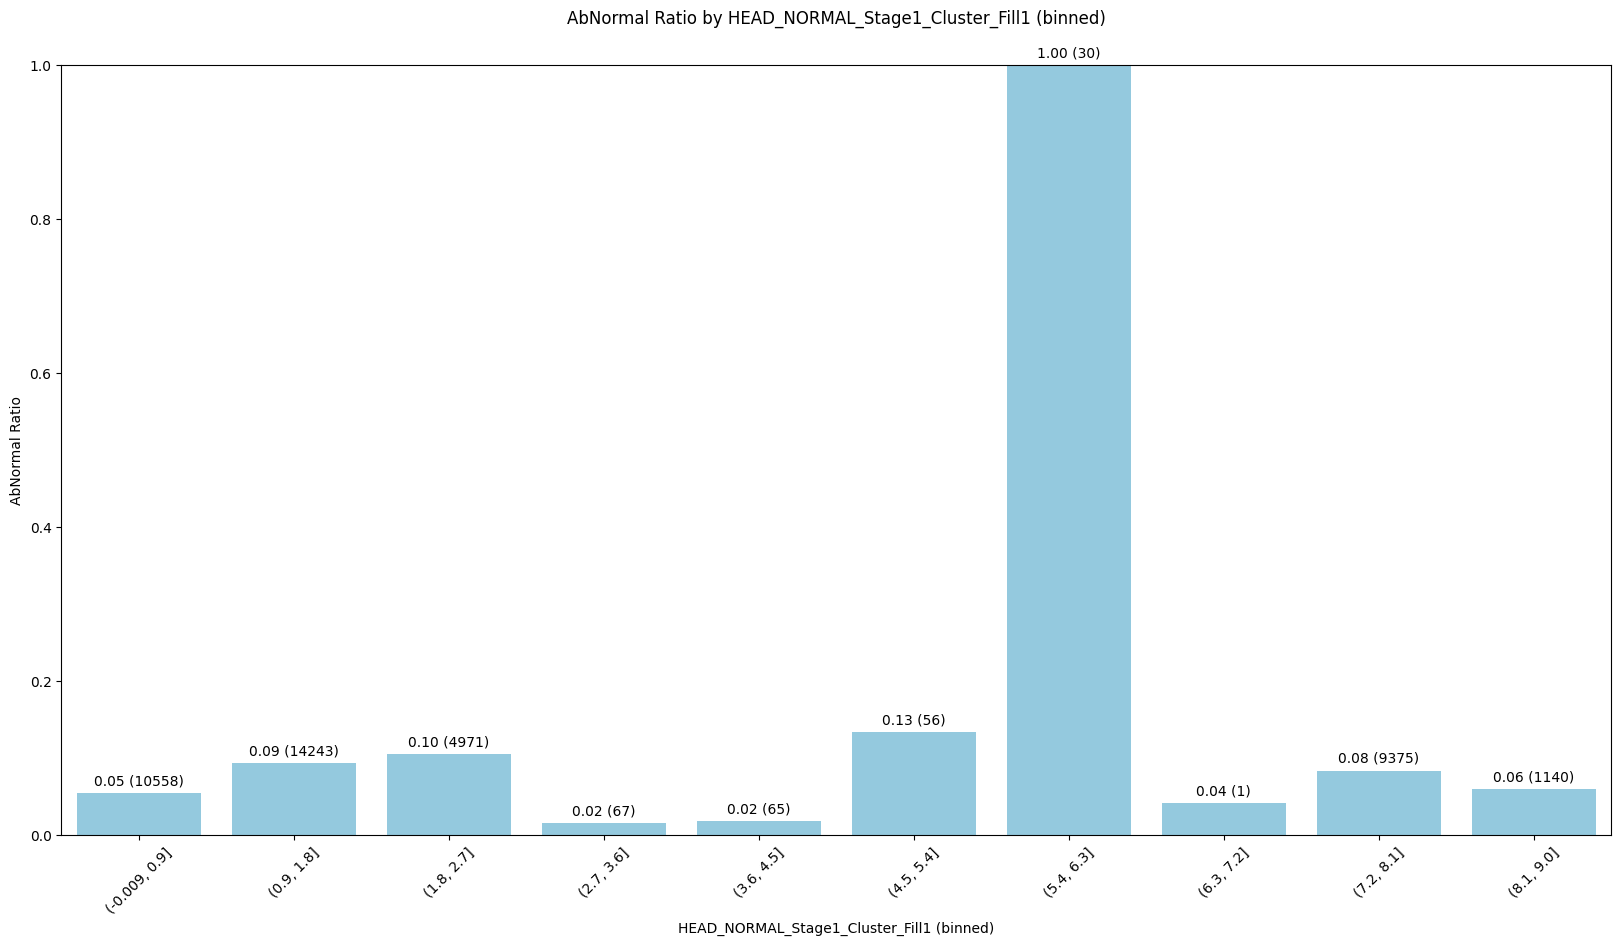

In [553]:
plot_abnormal_ratio(train_data, 'HEAD_NORMAL_Stage1_Cluster_Fill1', 'target', 'AbNormal', bins=10)

In [554]:
# HEAD NORMAL COORDINATE 관련 좌표 변수 drop
train_data = train_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'])
test_data = test_data.drop(columns=[
    'HEAD NORMAL COORDINATE X AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE X AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Y AXIS(Stage3) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage1) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage2) Collect Result_Fill1'
    , 'HEAD NORMAL COORDINATE Z AXIS(Stage3) Collect Result_Fill1'])

In [555]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
PalletID Collect Result_Fill1
Production Qty Collect Result_Fill1
Receip No Collect Result_Fill1
WorkMode Collect Result_Fill1
HEAD_NORMAL_Stage1_Cluster_Fill1
HEAD_NORMAL_Stage2_Cluster_Fill1
HEAD_NORMAL_Stage3_Cluster_Fill1


In [556]:
value_counts_ratio_count(train_data, 'Head Purge Position Z Collect Result_Fill1', 'target')


Head Purge Position Z Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
85        0.087580  0.912420       727    7574   8301
128       0.047102  0.952898       755   15274  16029
145       0.053660  0.946340       868   15308  16176


In [557]:
value_counts_ratio_count(train_data, 'Machine Tact time Collect Result_Fill1', 'target')


Machine Tact time Collect Result_Fill1별 target 비율 및 갯수

          AbNormal  Normal  AbNormal  Normal  Total
variable                                           
0.0            1.0     0.0       1.0     0.0      1
39.1           0.0     1.0       0.0     1.0      1
39.5           0.0     1.0       0.0     1.0      1
39.7           0.0     1.0       0.0     1.0      1
40.3           1.0     0.0       1.0     0.0      1
...            ...     ...       ...     ...    ...
172.3          1.0     0.0       1.0     0.0      1
175.9          0.0     1.0       0.0     1.0      1
187.1          0.0     1.0       0.0     1.0      1
203.8          0.0     1.0       0.0     1.0      1
214.9          0.0     1.0       0.0     1.0      1

[355 rows x 5 columns]


In [558]:
train_data['Machine Tact time Collect Result_Fill1'].describe()

count    40506.000000
mean        65.793347
std         14.754271
min          0.000000
25%         56.100000
50%         57.600000
75%         75.000000
max        214.900000
Name: Machine Tact time Collect Result_Fill1, dtype: float64

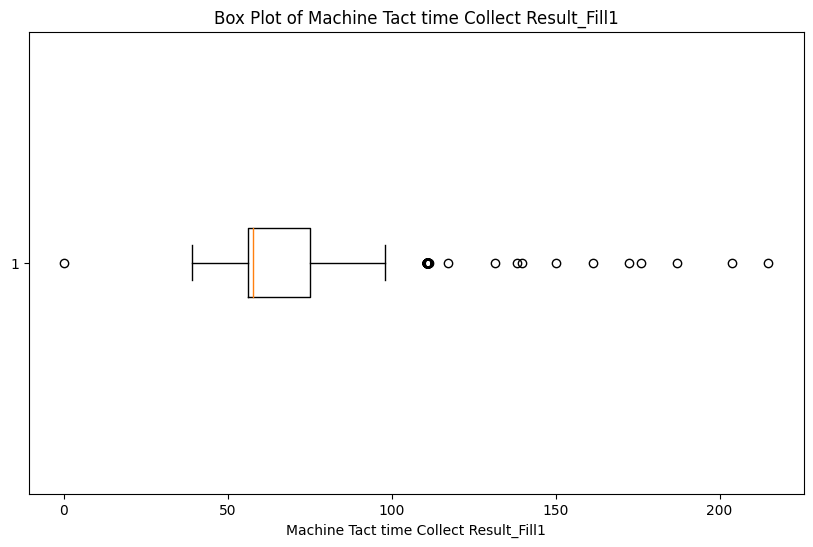

In [559]:
plot_box(train_data, 'Machine Tact time Collect Result_Fill1')

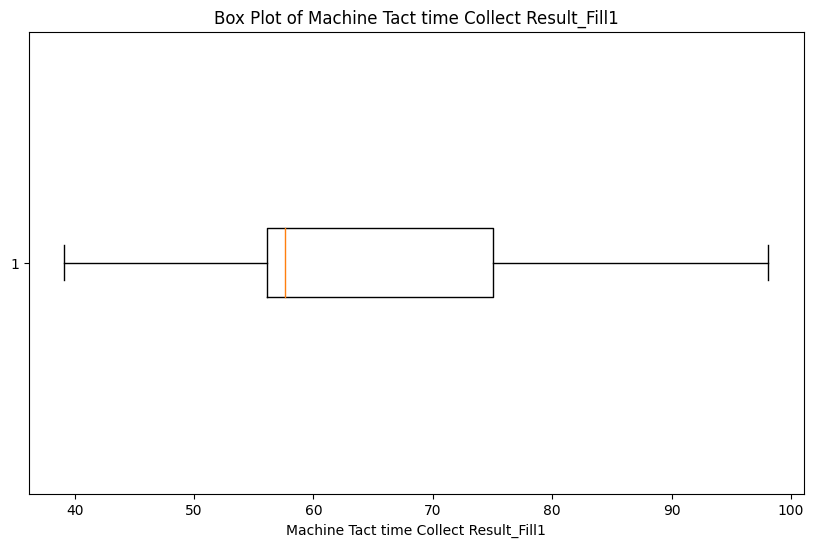

In [560]:
import pandas as pd

# IQR 기준으로 이상치 제거
def remove_outliers_iqr(data, column):
    Q1 = data[column].quantile(0.25)
    Q3 = data[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    filtered_data = data[(data[column] >= lower_bound) & (data[column] <= upper_bound)]
    return filtered_data

# 이상치 제거한 데이터프레임 생성
filtered_train_data = remove_outliers_iqr(train_data, 'Machine Tact time Collect Result_Fill1')

# 박스 플롯 그리기
plot_box(filtered_train_data, 'Machine Tact time Collect Result_Fill1')

In [561]:
filtered_train_data['Machine Tact time Collect Result_Fill1'].describe()

count    40386.000000
mean        65.647786
std         14.489605
min         39.100000
25%         56.100000
50%         57.600000
75%         75.000000
max         98.100000
Name: Machine Tact time Collect Result_Fill1, dtype: float64

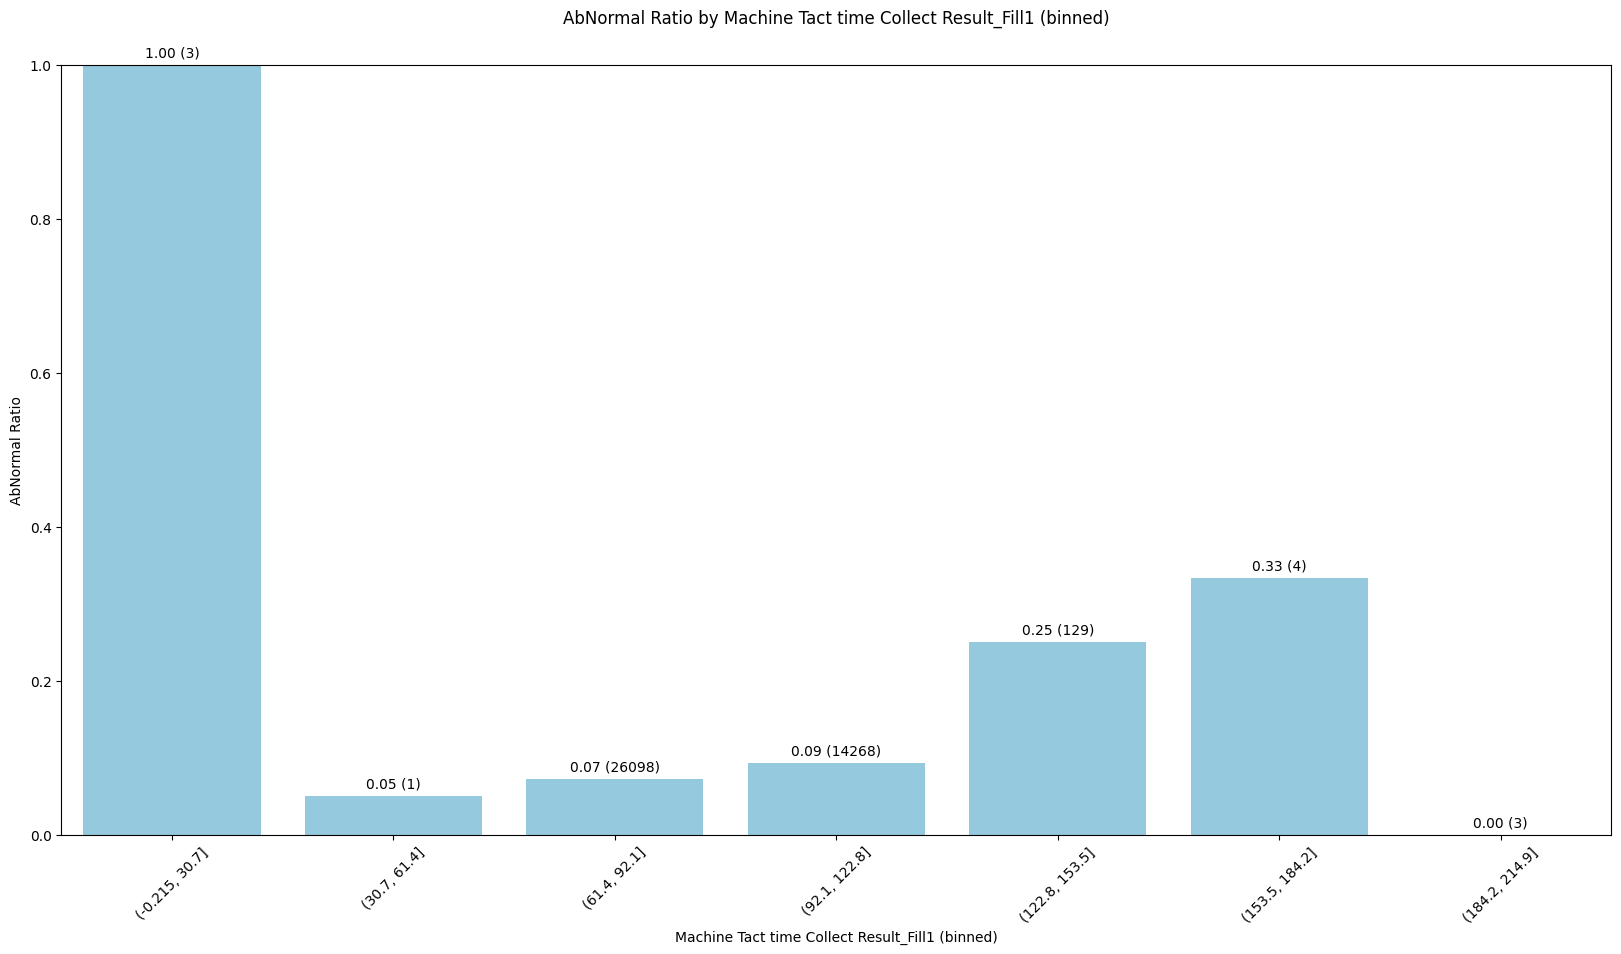

In [562]:
plot_abnormal_ratio(train_data, 'Machine Tact time Collect Result_Fill1', 'target', 'AbNormal', bins=7)

In [563]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
PalletID Collect Result_Fill1
Production Qty Collect Result_Fill1
Receip No Collect Result_Fill1
WorkMode Collect Result_Fill1
HEAD_NORMAL_Stage1_Cluster_Fill1
HEAD_NORMAL_Stage2_Cluster_Fill1
HEAD_NORMAL_Stage3_Cluster_Fill1


In [564]:
value_counts_ratio_count(train_data, 'PalletID Collect Result_Fill1', 'target')


PalletID Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
1         0.053600  0.946400       169    2984   3153
2         0.069241  0.930759       217    2917   3134
3         0.064648  0.935352       205    2966   3171
4         0.055660  0.944340       177    3003   3180
5         0.055951  0.944049       173    2919   3092
6         0.059634  0.940366       186    2933   3119
7         0.054763  0.945237       169    2917   3086
8         0.060155  0.939845       186    2906   3092
9         0.046924  0.953076        90    1828   1918
10        0.052058  0.947942       105    1912   2017
11        0.059131  0.940869       113    1798   1911
12        0.044301  0.955699        89    1920   2009
13        0.071690  0.928310       137    1774   1911
14        0.049445  0.950555        98    1884   1982
15        0.061507  0.938493       120    1831   1951
16        0.065169  0.934831      

In [565]:
value_counts_ratio_count(train_data, 'Receip No Collect Result_Fill1', 'target')


Receip No Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal   Normal  Total
variable                                              
1         0.056396  0.943604    2215.0  37061.0  39276
3         0.671875  0.328125      43.0     21.0     64
4         1.000000  0.000000       1.0      0.0      1
6         0.086470  0.913530      85.0    898.0    983
9         0.010417  0.989583       1.0     95.0     96
17        0.058140  0.941860       5.0     81.0     86


In [566]:
value_counts_ratio_count(train_data, 'WorkMode Collect Result_Fill1', 'target')


WorkMode Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
7.0       0.073326  0.926674      1206   15241  16447


In [567]:
# 'WorkMode Collect Result_Fill1' 열의 결측값을 0으로 채우기
train_data['WorkMode Collect Result_Fill1'].fillna(0, inplace=True)

# value_counts_ratio_count 함수 호출
value_counts_ratio_count(train_data, 'WorkMode Collect Result_Fill1', 'target')


WorkMode Collect Result_Fill1별 target 비율 및 갯수

          AbNormal    Normal  AbNormal  Normal  Total
variable                                             
0.0       0.047550  0.952450      1144   22915  24059
7.0       0.073326  0.926674      1206   15241  16447


In [568]:
# '_Fill1'를 포함하는 열 이름 필터링
Process_Desc_col = train_data.filter(like='_Fill1').columns

# 필터링된 열 이름 출력
print("<Fill1 공정 관련 변수>")
for col in Process_Desc_col:
    print(col)

<Fill1 공정 관련 변수>
DISCHARGED SPEED OF RESIN Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage1) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage2) Collect Result_Fill1
DISCHARGED TIME OF RESIN(Stage3) Collect Result_Fill1
Dispense Volume(Stage1) Collect Result_Fill1
Dispense Volume(Stage2) Collect Result_Fill1
Dispense Volume(Stage3) Collect Result_Fill1
Head Purge Position Z Collect Result_Fill1
Machine Tact time Collect Result_Fill1
PalletID Collect Result_Fill1
Production Qty Collect Result_Fill1
Receip No Collect Result_Fill1
WorkMode Collect Result_Fill1
HEAD_NORMAL_Stage1_Cluster_Fill1
HEAD_NORMAL_Stage2_Cluster_Fill1
HEAD_NORMAL_Stage3_Cluster_Fill1


## Fill2

---